### Prédiction en Time series

Dans cette partie, nous allons de réaliser une analyse en time series du retard des trains.
Dans la logique de la consigne, nous devons prédire le retard moyens des trains dans les mois de 2023, nous décidons donc de nous considérer pour l'entrainement comme étant le 31 décembre 2022, avec toutes les données historique. C'est pour cette raison que nous allons devoir retirer du dataset de test toutes les features que nous ne pouvons pas avoir au 31 decembre 2022


Ainsi, nous allons conserver uniquement la date, les gares de départ et d'arrivée ainsi que le nombre de trains prévus (nous supposons que cette donnée est disponible quelques mois à l'avance)

Nous allons ensuite conserver les features à prédire : le retard moyen à l'arrivée ainsi que les causes

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('csv_files/regularite-mensuelle-tgv-aqst.csv',sep=';')
df.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'commentaire_annulation',
       'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'commentaire_retards_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'commentaires_retard_arrivee',
       'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs'],
      dtype='object')

In [8]:
df_for_timeseries = df[["date", 
                        "gare_depart", 
                        "gare_arrivee", 
                        "nb_train_prevu",
                        "retard_moyen_tous_trains_arrivee",
                        'prct_cause_externe', 
                        'prct_cause_infra', 
                        'prct_cause_gestion_trafic',
                        'prct_cause_materiel_roulant', 
                        'prct_cause_gestion_gare',
                        'prct_cause_prise_en_charge_voyageurs']]

df_for_timeseries

,date,gare_depart,gare_arrivee,nb_train_prevu,retard_moyen_tous_trains_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,BORDEAUX ST JEAN,PARIS MONTPARNASSE,870,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,LA ROCHELLE VILLE,PARIS MONTPARNASSE,222,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,PARIS MONTPARNASSE,QUIMPER,248,7.578947,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,PARIS MONTPARNASSE,ST MALO,102,6.790686,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,PARIS MONTPARNASSE,ST PIERRE DES CORPS,391,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
8149,2023-06,STRASBOURG,PARIS EST,492,7.689898,7.619048,5.714286,55.238095,18.095238,7.619048,5.714286
8150,2023-06,TOULOUSE MATABIAU,PARIS MONTPARNASSE,215,14.824264,13.888889,33.333333,8.333333,19.444444,8.333333,16.666667
8151,2023-06,TOURS,PARIS MONTPARNASSE,192,8.650349,14.285714,21.428571,28.571429,21.428571,3.571429,10.714286
8152,2023-06,VALENCE ALIXAN TGV,PARIS LYON,440,12.765753,26.724138,19.827586,27.586207,7.758621,7.758621,10.344828


Pour une première analyse en timeseries, nous allons chercher à prédir uniquement le retard moyen.
Nous devons séparer le dataset en groupes, correspondant à chaque trajet. En effet, l'analyse en timeseries doit etre entrainée pour chaque trajet.

Créons les trajets :

In [13]:
df_pred_retard = df_for_timeseries[["date", 
                                    "gare_depart", 
                                    "gare_arrivee", 
                                    "nb_train_prevu",
                                    "retard_moyen_tous_trains_arrivee",
                                    ]]

df_pred_retard = df_pred_retard.assign(trajet=df_pred_retard["gare_depart"] + " - " + df_pred_retard["gare_arrivee"])

Réalisons l'analyse time series sur un premier trajet : Paris Montparnasse - Bordeaux Saint Jean

In [16]:
df_paris_bordeaux = df_pred_retard[df_pred_retard["trajet"]=="PARIS MONTPARNASSE - BORDEAUX ST JEAN"].reset_index(drop=True)
df_paris_bordeaux

,date,gare_depart,gare_arrivee,nb_train_prevu,retard_moyen_tous_trains_arrivee,trajet
0,2018-01,PARIS MONTPARNASSE,BORDEAUX ST JEAN,775,2.546962,PARIS MONTPARNASSE - BORDEAUX ST JEAN
1,2018-02,PARIS MONTPARNASSE,BORDEAUX ST JEAN,698,10.113599,PARIS MONTPARNASSE - BORDEAUX ST JEAN
2,2018-03,PARIS MONTPARNASSE,BORDEAUX ST JEAN,760,2.415507,PARIS MONTPARNASSE - BORDEAUX ST JEAN
3,2018-04,PARIS MONTPARNASSE,BORDEAUX ST JEAN,756,2.377624,PARIS MONTPARNASSE - BORDEAUX ST JEAN
4,2018-05,PARIS MONTPARNASSE,BORDEAUX ST JEAN,800,2.380243,PARIS MONTPARNASSE - BORDEAUX ST JEAN
...,...,...,...,...,...,...
61,2023-02,PARIS MONTPARNASSE,BORDEAUX ST JEAN,920,2.324686,PARIS MONTPARNASSE - BORDEAUX ST JEAN
62,2023-03,PARIS MONTPARNASSE,BORDEAUX ST JEAN,1035,4.061302,PARIS MONTPARNASSE - BORDEAUX ST JEAN
63,2023-04,PARIS MONTPARNASSE,BORDEAUX ST JEAN,1007,4.467371,PARIS MONTPARNASSE - BORDEAUX ST JEAN
64,2023-05,PARIS MONTPARNASSE,BORDEAUX ST JEAN,918,3.620593,PARIS MONTPARNASSE - BORDEAUX ST JEAN


Dans un premier temps, nous allons faire une analyse time series simple, sans paramètres supplémentaires (uniquement la date (step) et la feature à predire)

In [18]:
mini_df_paris_bordeaux = df_paris_bordeaux[["date", "retard_moyen_tous_trains_arrivee"]].rename(columns={"retard_moyen_tous_trains_arrivee":"retard"})

Affichons cette série

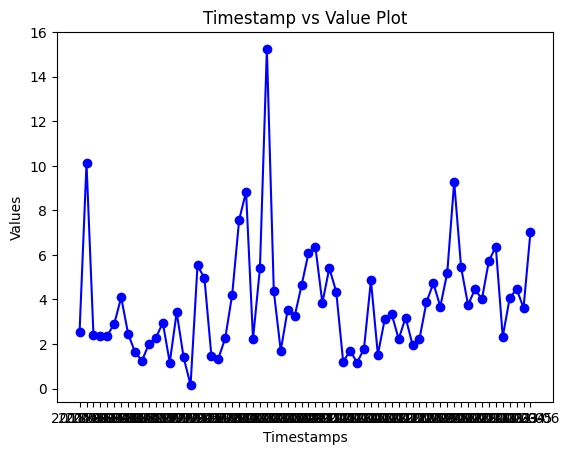

In [22]:
plt.plot(mini_df_paris_bordeaux["date"], mini_df_paris_bordeaux["retard"], marker='o', linestyle='-', color='b')
plt.xlabel('Timestamps')
plt.ylabel('Values')
plt.title('Timestamp vs Value Plot')
plt.show()